In [1]:
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import DataLoader, TensorDataset
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from sklearn.metrics import mean_squared_error

from models import *
from autoencoder import *
from utils import *
from data import *

In [2]:
import os, pickle
import time
import random
import warnings
warnings.filterwarnings("ignore")

In [3]:
ts_configs = [
    ("Births",       Births,       15),
    ("Temperatures", Temperatures, 15),
]
autoencoder_embedding_flags = [False, True]
metrics_list = ["euclidean", "manhattan", "cosine"]
latent_dim = 4

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda



Training AE on Births (window_size=15)
  Epoch 1/30 — loss: 0.649749
  Epoch 2/30 — loss: 0.394232
  Epoch 3/30 — loss: 0.244895
  Epoch 4/30 — loss: 0.171288
  Epoch 5/30 — loss: 0.148804
  Epoch 6/30 — loss: 0.138043
  Epoch 7/30 — loss: 0.131338
  Epoch 8/30 — loss: 0.127368
  Epoch 9/30 — loss: 0.125137
  Epoch 10/30 — loss: 0.123036
  Epoch 11/30 — loss: 0.121074
  Epoch 12/30 — loss: 0.119800
  Epoch 13/30 — loss: 0.118571
  Epoch 14/30 — loss: 0.117530
  Epoch 15/30 — loss: 0.116630
  Epoch 16/30 — loss: 0.116027
  Epoch 17/30 — loss: 0.115717
  Epoch 18/30 — loss: 0.115317
  Epoch 19/30 — loss: 0.114542
  Epoch 20/30 — loss: 0.114248
  Epoch 21/30 — loss: 0.114047
  Epoch 22/30 — loss: 0.113695
  Epoch 23/30 — loss: 0.113194
  Epoch 24/30 — loss: 0.112931
  Epoch 25/30 — loss: 0.112817
  Epoch 26/30 — loss: 0.112466
  Epoch 27/30 — loss: 0.112612
  Epoch 28/30 — loss: 0.112062
  Epoch 29/30 — loss: 0.111977
  Epoch 30/30 — loss: 0.111581
Saved AE: autoencoders\ae_Births.pth


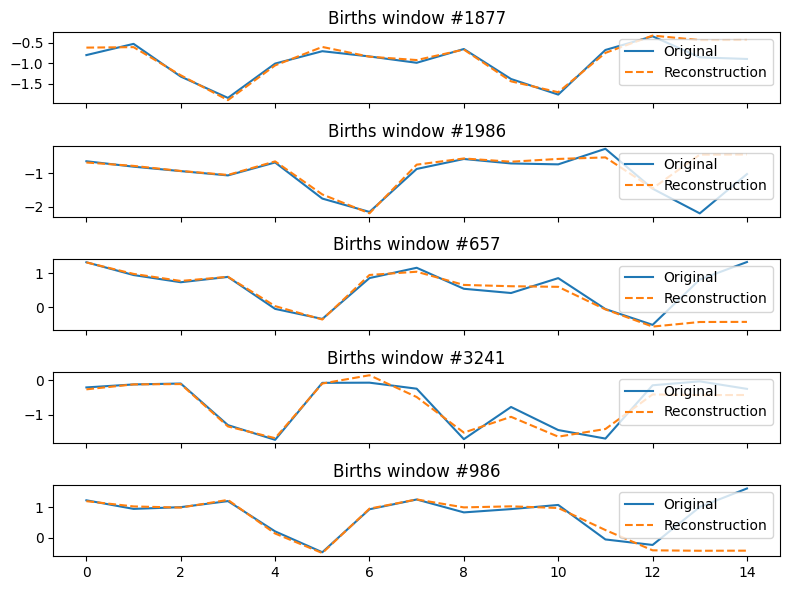


Training AE on Temperatures (window_size=15)
  Epoch 1/30 — loss: 1.032092
  Epoch 2/30 — loss: 0.545848
  Epoch 3/30 — loss: 0.416340
  Epoch 4/30 — loss: 0.388100
  Epoch 5/30 — loss: 0.383883
  Epoch 6/30 — loss: 0.379607
  Epoch 7/30 — loss: 0.376664
  Epoch 8/30 — loss: 0.373045
  Epoch 9/30 — loss: 0.368133
  Epoch 10/30 — loss: 0.357248
  Epoch 11/30 — loss: 0.338905
  Epoch 12/30 — loss: 0.323131
  Epoch 13/30 — loss: 0.301875
  Epoch 14/30 — loss: 0.286649
  Epoch 15/30 — loss: 0.278407
  Epoch 16/30 — loss: 0.272699
  Epoch 17/30 — loss: 0.273398
  Epoch 18/30 — loss: 0.269451
  Epoch 19/30 — loss: 0.266960
  Epoch 20/30 — loss: 0.267889
  Epoch 21/30 — loss: 0.265764
  Epoch 22/30 — loss: 0.264024
  Epoch 23/30 — loss: 0.263980
  Epoch 24/30 — loss: 0.261912
  Epoch 25/30 — loss: 0.261914
  Epoch 26/30 — loss: 0.263101
  Epoch 27/30 — loss: 0.264097
  Epoch 28/30 — loss: 0.259709
  Epoch 29/30 — loss: 0.258601
  Epoch 30/30 — loss: 0.260760
Saved AE: autoencoders\ae_Tempera

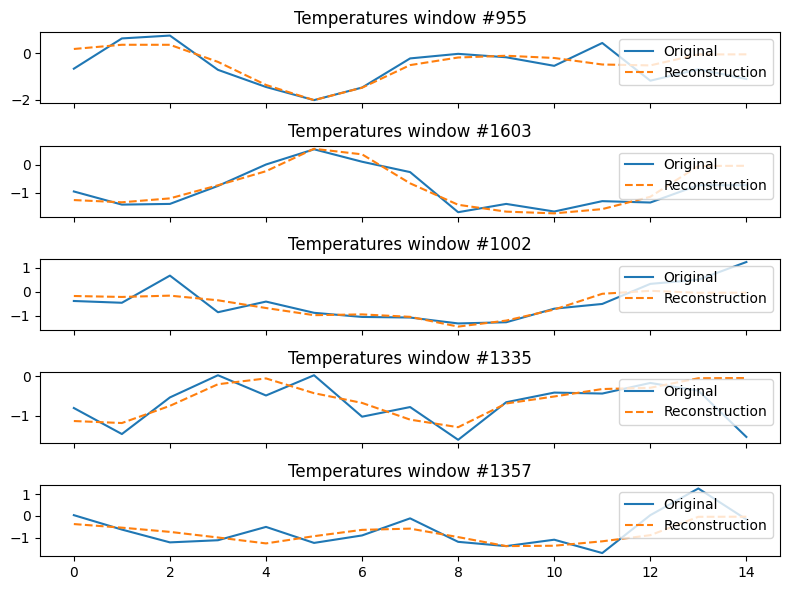

In [4]:
epochs = 30
lr     = 1e-3

for ds_name, DS, window_size in ts_configs:
    print(f"\nTraining AE on {ds_name} (window_size={window_size})")
    ts = DS(path=None, normalize=True)
    X_train, y_train, X_val, y_val, X_test, y_test = windowing(ts.data, window_size)
    
    
    # model + optimizer + loss
    ae        = ConvAutoencoder1D(window_size, latent_dim).to(device)
    optimizer = torch.optim.Adam(ae.parameters(), lr=lr)
    criterion = nn.MSELoss()
    
    # wrap as DataLoader of shape (batch, 1, window_size)
    ds_loader = DataLoader(
        TensorDataset(torch.tensor(X_train, dtype=torch.float).unsqueeze(1)),
        batch_size=64, shuffle=True
    )
    
    # training loop
    for epoch in range(1, epochs + 1):
        losses = []
        ae.train()
        for (batch_x,) in ds_loader:
            batch_x = batch_x.to(device)
            recon   = ae(batch_x)
            loss    = criterion(recon, batch_x)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            losses.append(loss.item())
        print(f"  Epoch {epoch}/{epochs} — loss: {np.mean(losses):.6f}")
    
    # save per‐dataset autoencoder
    ckpt_path = os.path.join("autoencoders", f"ae_{ds_name}.pth")
    torch.save(ae.state_dict(), ckpt_path)
    print(f"Saved AE: {ckpt_path}")

    # 6. Visualize reconstructions in eval mode
    ae.eval()
    sample_idxs = random.sample(range(len(X_train)), 5)
    fig, axes = plt.subplots(5, 1, figsize=(8, 6), sharex=True)
    for ax, idx in zip(axes, sample_idxs):
        orig = X_train[idx]
        with torch.no_grad():
            inp = torch.tensor(orig, dtype=torch.float).unsqueeze(0).unsqueeze(0).to(device)
            recon = ae(inp).cpu().squeeze().numpy()
        ax.plot(orig, label="Original")
        ax.plot(recon, linestyle="--", label="Reconstruction")
        ax.set_title(f"{ds_name} window #{idx}")
        ax.legend(loc="upper right")
    plt.tight_layout()
    plt.show()

In [5]:
for ds_name, DS, window_size in ts_configs:
    print(f"\n→ Dataset: {ds_name} (window_size={window_size})")
    ts = DS(path=None, normalize=True)
    X_train, y_train, X_val, y_val, X_test, y_test = windowing(ts.data, window_size)

    forecasters = {
    "ARIMA": ARIMAForecaster(),
    "ExpSmoothing": ExpSmoothingForecaster(),
    "LinearRegression": LinearRegressionForecaster(),
    "RandomForest": RandomForestForecaster(),
    "SVR": SVRForecaster(),
    "GradientBoosting": GradientBoostingForecaster(),
    "DT": DecisionTreeForecaster(),
    "MLP": MLPForecaster(),
    "LSTM": LSTMForecaster(window_size=window_size),
    "BiLSTM": BiLSTMForecaster(window_size=window_size),
    "CNNLSTM": CNNLSTMForecaster(window_size=window_size),
    }

    for name, model in forecasters.items():
        print(f"    → Training {name}…", end=" ")
        model.fit(X_train, y_train)

        # save the entire model object as a .pkl
        save_path = os.path.join("models", f"{ds_name}_{name}.pkl")
        with open(save_path, "wb") as f:
            pickle.dump(model, f)
        print(f"DONE: {save_path}")


→ Dataset: Births (window_size=15)
    → Training ARIMA… DONE: models\Births_ARIMA.pkl
    → Training ExpSmoothing… DONE: models\Births_ExpSmoothing.pkl
    → Training LinearRegression… DONE: models\Births_LinearRegression.pkl
    → Training RandomForest… DONE: models\Births_RandomForest.pkl
    → Training SVR… DONE: models\Births_SVR.pkl
    → Training GradientBoosting… DONE: models\Births_GradientBoosting.pkl
    → Training DT… DONE: models\Births_DT.pkl
    → Training MLP… DONE: models\Births_MLP.pkl
    → Training LSTM… 1/30 0.43208 | 15/30 0.06631 | 30/30 0.05236 | DONE: models\Births_LSTM.pkl
    → Training BiLSTM… 1/30 0.43292 | 15/30 0.07231 | 30/30 0.06003 | DONE: models\Births_BiLSTM.pkl
    → Training CNNLSTM… 1/30 0.32738 | 15/30 0.06396 | 30/30 0.05443 | DONE: models\Births_CNNLSTM.pkl

→ Dataset: Temperatures (window_size=15)
    → Training ARIMA… DONE: models\Temperatures_ARIMA.pkl
    → Training ExpSmoothing… DONE: models\Temperatures_ExpSmoothing.pkl
    → Training Li

In [6]:
MODELS_DIR = "models"
AE_DIR = "autoencoders"

loaded = {}
for ds_name, DS, window_size in ts_configs:
    print(f"\n→ Loading models for {ds_name} (window_size={window_size})")
    
    # 1) Load Autoencoder
    ae = ConvAutoencoder1D(window_size, latent_dim).eval().to(device)
    ae_ckpt = os.path.join(AE_DIR, f"ae_{ds_name}.pth")
    ae.load_state_dict(torch.load(ae_ckpt, map_location=device))
    print(f"     AE loaded from {ae_ckpt}")
    
    # 2) Load Forecasters
    forecasters = {}
    for name in [
        "ARIMA","ExpSmoothing","LinearRegression","RandomForest",
        "SVR","GradientBoosting","DT","MLP","LSTM","BiLSTM","CNNLSTM"
    ]:
        pkl_path = os.path.join(MODELS_DIR, f"{ds_name}_{name}.pkl")
        with open(pkl_path, "rb") as f:
            forecasters[name] = pickle.load(f)
        print(f"     {name} loaded from {pkl_path}")
    
    # store for later
    loaded[ds_name] = {
        "ae": ae,
        "forecasters": forecasters
    }


→ Loading models for Births (window_size=15)
     AE loaded from autoencoders\ae_Births.pth
     ARIMA loaded from models\Births_ARIMA.pkl
     ExpSmoothing loaded from models\Births_ExpSmoothing.pkl
     LinearRegression loaded from models\Births_LinearRegression.pkl
     RandomForest loaded from models\Births_RandomForest.pkl
     SVR loaded from models\Births_SVR.pkl
     GradientBoosting loaded from models\Births_GradientBoosting.pkl
     DT loaded from models\Births_DT.pkl
     MLP loaded from models\Births_MLP.pkl
     LSTM loaded from models\Births_LSTM.pkl
     BiLSTM loaded from models\Births_BiLSTM.pkl
     CNNLSTM loaded from models\Births_CNNLSTM.pkl

→ Loading models for Temperatures (window_size=15)
     AE loaded from autoencoders\ae_Temperatures.pth
     ARIMA loaded from models\Temperatures_ARIMA.pkl
     ExpSmoothing loaded from models\Temperatures_ExpSmoothing.pkl
     LinearRegression loaded from models\Temperatures_LinearRegression.pkl
     RandomForest loaded fro

In [7]:
for ds_name, DS, window_size in ts_configs:
    print(f"\n=== Validation RoC for {ds_name} (window_size={window_size}) ===")
    
    # Load data
    ts = DS(path=None, normalize=True)
    X_train, y_train, X_val, y_val, X_test, y_test = windowing(ts.data, window_size)

    # Load models
    ae          = loaded[ds_name]["ae"]
    forecasters = loaded[ds_name]["forecasters"]

    # Clear both RoCs
    for model in forecasters.values():
        model.rocs["raw"].clear()
        model.rocs["latent"].clear()

    # Iterate once over validation windows
    for idx, window in enumerate(X_val):
        # a) Pick winner based on raw input
        errors = {}
        for name, model in forecasters.items():
            y_pred = model.predict(window)
            errors[name] = mean_squared_error([y_val[idx]], [y_pred])
        winner = min(errors, key=errors.get)

        # b) Store both raw and latent versions
        raw_vec = window
        with torch.no_grad():
            latent_vec = ae.encode(window).cpu()

        forecasters[winner].rocs["raw"].append(raw_vec)
        forecasters[winner].rocs["latent"].append(latent_vec)

    # Report results
    print("RoC sizes")
    for name, model in forecasters.items():
        count = len(model.rocs["raw"])
        print(f"  {name:<18} {count:4d} entries")



=== Validation RoC for Births (window_size=15) ===
RoC sizes
  ARIMA               117 entries
  ExpSmoothing         52 entries
  LinearRegression    209 entries
  RandomForest        189 entries
  SVR                 160 entries
  GradientBoosting    238 entries
  DT                  191 entries
  MLP                 229 entries
  LSTM                135 entries
  BiLSTM              139 entries
  CNNLSTM             152 entries

=== Validation RoC for Temperatures (window_size=15) ===
RoC sizes
  ARIMA               103 entries
  ExpSmoothing         69 entries
  LinearRegression     47 entries
  RandomForest         92 entries
  SVR                  78 entries
  GradientBoosting     60 entries
  DT                  143 entries
  MLP                  48 entries
  LSTM                 75 entries
  BiLSTM               66 entries
  CNNLSTM             116 entries


In [8]:
print(f"Bottleneck size: {latent_dim}")
for ds_name, DS, window_size in ts_configs:
    print(f"\n=== Dataset: {ds_name} ===")
    # rebuild all splits
    X_train, y_train, X_val, y_val, X_test, y_test = windowing(ts.data, window_size)
    # ensure y_true is ndarray
    y_true = y_test if isinstance(y_test, np.ndarray) else y_test.cpu().numpy()

    ae = loaded[ds_name]["ae"]
    forecasters = loaded[ds_name]["forecasters"]

    for metric in metrics_list:
        for embed in autoencoder_embedding_flags:
            mode = "latent" if embed else "raw"
            t0 = time.perf_counter()

            preds = []
            for w in X_test:
                # 1) build query
                if embed:
                    with torch.no_grad():
                        q = ae.encode(w).cpu()      # q is a torch.Tensor
                else:
                    q = w                           # q is a np.ndarray

                # 2) nearest‐RoC lookup
                best_name, best_dist = None, float("inf")
                space = "latent" if embed else "raw"
                for name, model in forecasters.items():
                    for entry in model.rocs[space]:
                        if embed: entry.cpu()
                        d = compute_distance(q, entry, metric=metric)
                        if d < best_dist:
                            best_dist, best_name = d, name

                # 3) predict
                preds.append(forecasters[best_name].predict(w))

            # 4) compute & print MSE
            mse = mean_squared_error(y_true, preds)

            elapsed = time.perf_counter() - t0

            print(f"[{mode:^6}, {f'{metric:^9}':<9}]  Test MSE: {mse:.6f}  Time: {elapsed:.2f}s")

Bottleneck size: 4

=== Dataset: Births ===
[ raw  , euclidean]  Test MSE: 0.511404  Time: 4.23s
[latent, euclidean]  Test MSE: 0.498505  Time: 11.19s
[ raw  , manhattan]  Test MSE: 0.528435  Time: 4.98s
[latent, manhattan]  Test MSE: 0.500780  Time: 11.76s
[ raw  ,  cosine  ]  Test MSE: 0.502288  Time: 7.40s
[latent,  cosine  ]  Test MSE: 0.481001  Time: 24.53s

=== Dataset: Temperatures ===
[ raw  , euclidean]  Test MSE: 0.456187  Time: 3.88s
[latent, euclidean]  Test MSE: 0.404300  Time: 7.61s
[ raw  , manhattan]  Test MSE: 0.448533  Time: 4.47s
[latent, manhattan]  Test MSE: 0.416017  Time: 8.01s
[ raw  ,  cosine  ]  Test MSE: 0.428615  Time: 6.08s
[latent,  cosine  ]  Test MSE: 0.449243  Time: 15.01s
